In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return pd.Series(result)

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return pd.Series(result)

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None):
    E = 0
    E_y = 0
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
        E_y = y[0].E
    else:
        y_value = y
        y_error = [0]*len(y_value)
    plt.grid(True)
    plt.plot(x_value, y_value, "o")
    k, b = mnk_non_zero(x_value, y_value)
    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin,xmax])
    print(type(xl))
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)

    k *= 10**E
    k.E = E
    b *= 10**E_y
    b.E = E_y
    
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    E = 0
    E_y = 0
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
        E_y = y[0].E
    else:
        y_value = y
        y_error = [0]*len(x_value)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)

    print("k, b =", k, b)
    k *= 10**E
    k.E = E
    b *= 10**E_y
    b.E = E_y
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))

def sin_ddata(angle):
    if isinstance(angle, DData):
        return(DData(np.sin(angle.value), abs(np.cos(angle.value))*angle.delta))
    elif isinstance(angle, pd.Series):
        arr = []
        for x in angle:
            arr.append(sin_ddata(x))
        return pd.Series(arr)

def cos_ddata(angle):
    if isinstance(angle, DData):
        return(DData(np.cos(angle.value), abs(np.sin(angle.value))*angle.delta))
    elif isinstance(angle, pd.Series):
        arr = []
        for x in angle:
            arr.append(cos_ddata(x))
        return pd.Series(arr)
    
def tg_ddata(angle):
    if isinstance(angle, DData):
        return(DData(np.tan(angle.value), 1/abs(np.cos(angle.value))**2 * angle.delta))
    elif isinstance(angle, pd.Series):
        arr = []
        for x in angle:
            arr.append(tg_ddata(x))
        return pd.Series(arr)


<>:235: SyntaxWarning: invalid escape sequence '\p'
<>:238: SyntaxWarning: invalid escape sequence '\p'
<>:240: SyntaxWarning: invalid escape sequence '\p'
<>:240: SyntaxWarning: invalid escape sequence '\c'
<>:243: SyntaxWarning: invalid escape sequence '\p'
<>:235: SyntaxWarning: invalid escape sequence '\p'
<>:238: SyntaxWarning: invalid escape sequence '\p'
<>:240: SyntaxWarning: invalid escape sequence '\p'
<>:240: SyntaxWarning: invalid escape sequence '\c'
<>:243: SyntaxWarning: invalid escape sequence '\p'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_19280\3191060284.py:235: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str} \pm {delta_str}$"
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_19280\3191060284.py:238: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str}")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_19280\3191060284.py:240: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str} \cdot 10

In [3]:
data = pd.read_csv("scope_csv_0.csv")
data

,Time [s],CH0 [V],CH1 [V],CH2 [V]
1.792000,1.36,0.364,-2.0,NaN
1.792008,1.34,0.364,-2.0,NaN
1.792016,1.38,0.364,-2.0,NaN
1.792024,1.30,0.364,-2.0,NaN
1.792032,1.32,0.364,-2.0,NaN
...,...,...,...,...
1.823960,-0.30,-0.032,1.6,NaN
1.823968,-0.28,-0.032,1.6,NaN
1.823976,-0.34,-0.032,1.8,NaN
1.823984,-0.28,-0.032,1.8,NaN


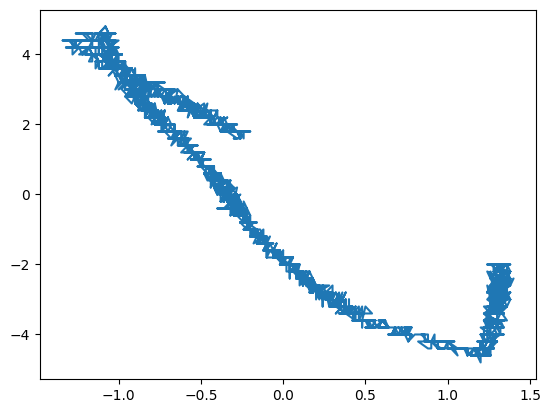

In [4]:
plt.plot(data["Time [s]"], data["CH1 [V]"])

In [5]:
raw_data = open("data_raw.txt", "r")
while True:
    line = raw_data.readline()
    if not line:
        break
    if line.startswith("#CHANNEL"):
        output_file = open("data_parced_{}".format(line.split(":")[1][:-1]),"w+")
        size_line = raw_data.readline()
        size = int(size_line.strip().split('=')[1])
        header_line = raw_data.readline()
        output_file.write(header_line)
        for i in range(size):
            output_file.write(raw_data.readline())
        output_file.close()
    
# Close the output_file if it is still open
try:
    output_file.close()
except Exception:
    pass

raw_data.close()
data_1 = pd.read_csv("data_parced_CH1")
data_2 = pd.read_csv("data_parced_CH2")
data_3 = pd.read_csv("data_parced_CH3")

data = pd.DataFrame()
data["Time, s"] = data_1["Time(s)"]
data["V_1"] = data_1["Volt(V)"]
data["V_2"] = data_2["Volt(V)"]
data["V_3"] = data_3["Volt(V)"]
data


,"Time, s",V_1,V_2,V_3
0,0.000000,1.20,0.464,-2.08
1,0.000008,1.14,0.464,-2.00
2,0.000016,1.18,0.464,-2.08
3,0.000024,1.20,0.464,-2.00
4,0.000032,1.20,0.464,-2.00
...,...,...,...,...
3995,0.031960,-0.18,0.056,1.76
3996,0.031968,-0.18,0.056,1.68
3997,0.031976,-0.14,0.056,1.76
3998,0.031984,-0.12,0.064,1.76


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_19280\1136144393.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_data["V_cutted"] = -cut_data["V_2"] + k.value*cut_data["Time, s"] + b.value


$-45.50 \pm 0.46$ $0.5369 \pm 0.0077$


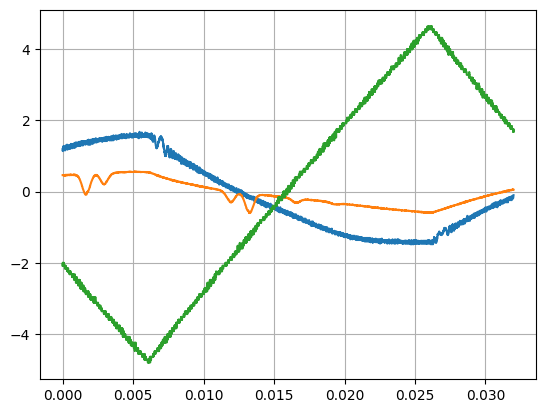

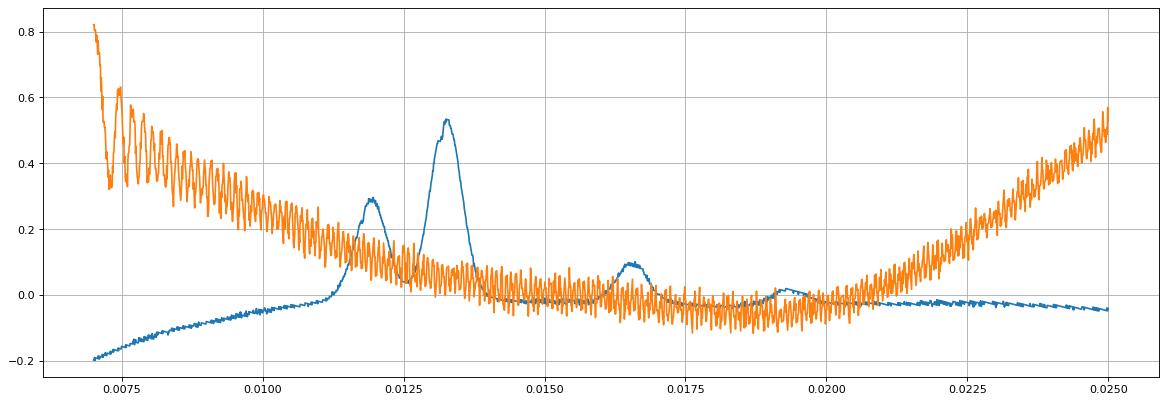

In [6]:
plt.plot(data["Time, s"], data["V_1"])
plt.plot(data["Time, s"], data["V_2"])
plt.plot(data["Time, s"], data["V_3"])
plt.grid()
cut_data = data[(data["Time, s"] >= 0.007) & (data["Time, s"] <= 0.025)]

k,b = mnk_non_zero(cut_data["Time, s"], cut_data["V_2"])
cut_data["V_cutted"] = -cut_data["V_2"] + k.value*cut_data["Time, s"] + b.value
plt.figure(figsize=(18, 6), dpi=80)
plt.plot(cut_data["Time, s"], cut_data["V_cutted"])
plt.plot(cut_data["Time, s"], cut_data["V_1"]-(-2.65/0.018)*cut_data["Time, s"]-1.75)
plt.grid()
print(k,b)


In [7]:
c = 3E+8
a = 1
dnu = c/(4*a)
print(dnu*1E-6, 'MHz')

75.0 MHz


In [8]:
d1 = 15
d2 = 37
d3 = 34

In [9]:
dnu1 = d1*dnu
dnu2 = d2*dnu
dnu3 = d3*dnu
print((dnu1)*1E-6,(dnu2)*1E-6,(dnu3)*1E-6, 'MHz')

1125.0 2775.0 2550.0 MHz


In [10]:
import math

In [11]:
k = -2.25/0.018

In [12]:
Nu = 384E+12

In [13]:
aum = 1.67E-27

In [14]:
fwhm = (8*1.38E-23*300*math.log(2)/(((3E+8)**2)*aum*85))**(0.5)*Nu/(1E+6)
fwhm

514.7545164435054

In [15]:
nus_true = np.array([-2563,-1265,1770,4271])

In [16]:
print((dnu1)*1E-6,(dnu2)*1E-6,(dnu3)*1E-6, 'MHz'," - мы")
print(nus_true[1]-nus_true[0],nus_true[2]-nus_true[1],nus_true[3]-nus_true[2],"MHz"," - таблица")

1125.0 2775.0 2550.0 MHz  - мы
1298 3035 2501 MHz  - таблица


In [17]:
add_nu_all = np.array([[194,-72,-230],[100,-20,-84],[-20,-84,-113],[-72,-74,-302]])
weights = [14/6,][][][]


SyntaxError: invalid syntax (2405726111.py, line 2)

In [ ]:
nus_true_w = np.round(nus_true + add_nu_weighted,0)
print((dnu1)*1E-6,(dnu2)*1E-6,(dnu3)*1E-6, 'MHz'," - мы")
print(nus_true_w[1]-nus_true_w[0],nus_true_w[2]-nus_true_w[1],nus_true_w[3]-nus_true_w[2],"MHz"," - таблица")

Fitted Parameters
 Gaussian Amplitude   Mean   Std Dev
        1    0.3121 0.0119 0.0002995
        2    0.5553 0.0133 0.0002909
        3    0.1238 0.0165 0.0002978
        4    0.0464 0.0194 0.0002987



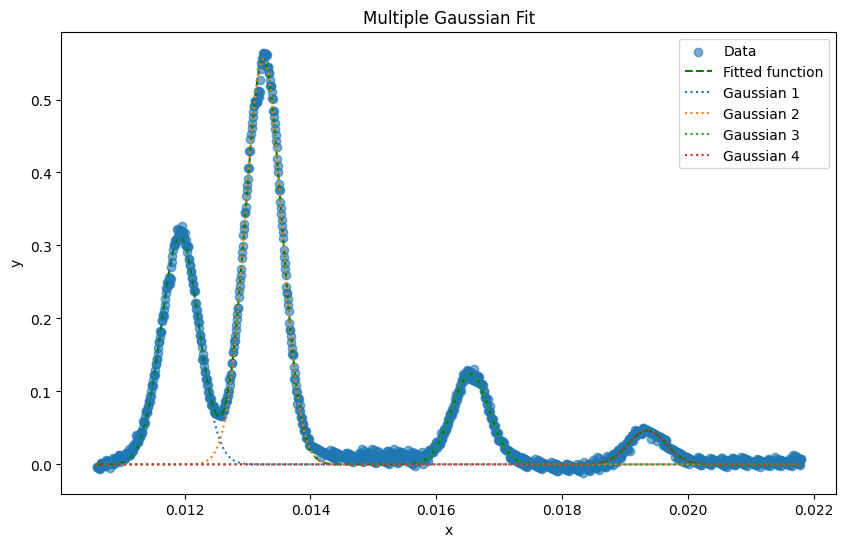

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))
shiftl,shiftr = 450,-400
x,y = cut_data["Time, s"][shiftl:shiftr], cut_data["V_cutted"][shiftl:shiftr]+cut_data["Time, s"][shiftl:shiftr]**0*0.03

def multi_gaussian(x, *params):
    """Function for multiple Gaussians"""
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        amplitude = params[i]
        mean = params[i+1]
        stddev = params[i+2]
        y += gaussian(x, amplitude, mean, stddev)
    return y

# Initial guess for two Gaussians
initial_guess = [0.3, 0.012, 0.0004,  # First Gaussian
                0.5, 0.013, 0.0004,
                0.1,0.017,0.0004,
                0.05,0.019,0.0004]  # Second Gaussian

# Fit multiple Gaussians
popt, pcov = curve_fit(multi_gaussian, x, y, p0=initial_guess, maxfev=5000)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data', alpha=0.6)
# plt.plot(x, y_true, 'r-', label='True function')
plt.plot(x, multi_gaussian(x, *popt), 'g--', label='Fitted function')

# Plot individual Gaussians
for i in range(0, len(popt), 3):
    plt.plot(x, gaussian(x, *popt[i:i+3]), ':', 
             label=f'Gaussian {i//3 + 1}')
    

perr = np.sqrt(np.diag(pcov))  # Parameter errors

# Create parameter table
n_gaussians = len(popt) // 3
parameters = []

for i in range(n_gaussians):
    idx = i * 3
    params = {
        'Gaussian': i + 1,
        'Amplitude': f"{popt[idx]:.4f}",# ± {perr[idx]:.4f}",
        'Mean': f"{popt[idx+1]:.4f}",# ± {perr[idx+1]:.4f}",
        'Std Dev': f"{popt[idx+2]:.7f}"# ± {perr[idx+2]:.7f}",
    }
    parameters.append(params)

# Create pandas DataFrame for nice display
df = pd.DataFrame(parameters)
print("Fitted Parameters")
print("="*80)
print(df.to_string(index=False))
print("\n" + "="*80)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Multiple Gaussian Fit')
plt.show()

[1.36e-04 1.36e-04 1.12e-04 1.28e-04 1.12e-04 1.28e-04 1.04e-04 1.04e-04
 9.60e-05 1.20e-04 9.60e-05 9.60e-05 1.20e-04 9.60e-05 8.80e-05 9.60e-05
 1.20e-04 7.20e-05 8.00e-05 4.00e-05 9.60e-05 8.00e-05 9.60e-05 9.60e-05
 9.60e-05 9.60e-05 8.80e-05 9.60e-05 8.00e-05 9.60e-05 8.80e-05 8.80e-05
 8.80e-05 5.60e-05 4.80e-05 8.00e-05 8.80e-05 9.60e-05 8.80e-05 8.00e-05
 1.04e-04 8.00e-05 9.60e-05 8.00e-05 8.00e-05 9.60e-05 7.20e-05 1.04e-04
 7.20e-05 9.60e-05 8.00e-05 8.80e-05 1.04e-04 9.60e-05 5.60e-05 8.80e-05
 9.60e-05 8.80e-05 9.60e-05 7.20e-05 9.60e-05 4.00e-05 4.80e-05 8.00e-05
 8.80e-05 9.60e-05 6.40e-05 1.04e-04 7.20e-05 8.80e-05 8.80e-05 9.60e-05
 8.80e-05 7.20e-05 7.20e-05 1.12e-04 8.00e-05 8.80e-05 8.00e-05 9.60e-05
 8.00e-05 8.80e-05 8.00e-05 8.00e-05 8.80e-05 9.60e-05 8.00e-05 8.00e-05
 8.80e-05 9.60e-05 8.80e-05 8.00e-05 8.80e-05 7.20e-05 1.12e-04 5.60e-05
 8.80e-05 9.60e-05 8.80e-05 7.20e-05 9.60e-05 7.20e-05 8.80e-05 1.04e-04
 8.00e-05 8.00e-05 7.20e-05 8.80e-05 7.20e-05 1.20e

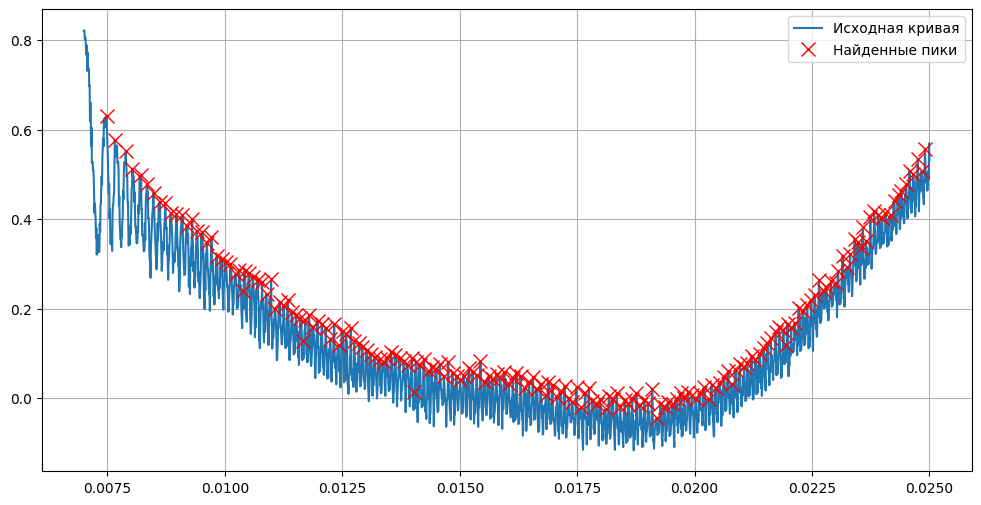

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Допустим, у нас есть массив y с значениями кривой
x=cut_data["Time, s"]
y=cut_data["V_1"]-(-2.65/0.018)*cut_data["Time, s"]-1.75
# Находим пики (локальные максимумы)
peaks, _ = find_peaks(np.array(y),   
    distance=5,          # минимум 50 точек между пиками
    prominence=0.03,       # минимальная "выдающаяся" высота
    width=1 )

# Визуализируем результат
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Исходная кривая')
plt.plot(np.array(x)[peaks], np.array(y)[peaks], "rx", markersize=10, label='Найденные пики')
peaksx = np.array(x)[peaks]
distances = peaksx*0
for i in range(len(peaksx)-1):
    distances[i] = peaksx[i+1]-peaksx[i]
print(np.array(distances)[5:])
plt.legend()
plt.grid(True)
plt.show()